## Introduction of this file

In [63]:
print("This is one of exercises of the course computational finance")
print("FDM and FEM in this exercise are used")
print("Author: Zhirui Tang")

This is one of exercises of the course computational finance
FDM and FEM in this exercise are used
Author: Zhirui Tang


# Finite Difference and Finite Element Methods for Option Pricing
Let us consider the Black-Scholes PDE
$$
  \frac{\partial V}{\partial
 t} + \frac{1}{2}\sigma^2S^2\frac{\partial^2 V}{\partial S^2} + rS\frac{\partial V}{\partial S} - rV = 0, \quad S\geq0,\quad t \in [0, T], 
$$
which can be transformed to the heat equation
$$
  \frac{\partial u}{\partial \tau} = \frac{\partial^2 u}{\partial x^2},
$$
using the following transformation
$$
  x = \ln\left(\frac{S}{k}\right), \quad \tau = \frac{1}{2}\sigma^2(T-t), \quad v(\tau, x) = \frac{V}{K}
$$
and
$$
  u(\tau, x) = v(\tau, x) e^{-\alpha x - \beta \tau}
$$
with $\alpha = \left( \frac{1}{2}  - \frac{r}{\sigma^2}\right)$ and $\beta = -\frac{1}{4}\left( \frac{2r}{\sigma^2} + 1\right)^2$, in the domain $x \in \mathbb{R}$ and $\tau \in [0, \frac{1}{2}\sigma^2T]$.

## Part 1: Finite difference method

**FDM**: Implement the Crank-Nicolson finite difference method to solve the heat equation and perform a backward transformation to derive the option price V.
Consider a European Call-option and use its payoff value $V(S, T) = (S − K)^+$ and the boundary conditions $V(0, t) = 0, V (S_{max}, t) = S_{max} − Ke^{
−r(T −t)}$ to determine the initial value and boundary conditions for that heat equation.
*   Visualize the solutions in three-dimensional plot for parameters $r = 0.05, \sigma = 0.3, K = 10, T = 1, S_{max} = 30, S_{min} = 3$. Try different choices of step sizes $\Delta t$ and $\Delta S$.
*   Compare the approximations of the price $V$ at the grid points within the layer $t = 0$ to the exact fair price obtained from the Black-Scholes formula.




## Import all necessary modules

In [64]:
import math
import numpy as np
from scipy.sparse import diags
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.interpolate import interp1d
from prettytable import PrettyTable


## Test Parameters

In [65]:
# Input parameters
sigma = 0.3
K = 10
S_min = 3
S_max = 30
r = 0.05
T = 1

## Define the following functions that incorporate the transformed boundary conditions and initial condition for an European Call option

In [66]:
def gamma1(tau, x_min, k):
    """
      Function that return BC at x_min for a call option
      Input:  tau   -> time value
              x_min -> minimum space value
              k     -> constant, k = (2r)/sigma^2

      Output: BC value at x_min

    """
    BC = 0
    return BC

In [67]:
def gamma2(tau, x_max, k):
    """
      Function that return BC at x_max for a call option

      ################# NOTE ###########################
        gamma2 = exp(0.5*(k+1)*x_max + 0.25*(k+1)**2*tau) - exp(0.5*(k-1)*x_max + 0.25*(k-1)**2*tau)

      Input:  tau   -> time value
              x_max -> maximim space value
              k     -> constant, k = (2r)/sigma^2

      Output: BC value at x_max

    """
    BC = np.exp(0.5*(k+1)*x_max + 0.25*(k+1)**2*tau) - np.exp(0.5*(k-1)*x_max + 0.25*(k-1)**2*tau)
    return BC

In [68]:
def u0(x, k):
    """
      Function that return IC at tau = 0 for a call option

      Input:  x   -> space domain
              k   -> constant, k = (2r)/sigma^2

      Output: IC value at tau = 0

    """
    IC = np.exp(0.5*(k-1)*x)*np.maximum(np.zeros((len(x))), np.exp(x)-1)
    return IC

## Define a function to perform the Crank-Nicolson finite difference method

In [69]:
def CN_fdm(M, N, l, tau, x, k):
    """
      Function that return the solution of the heat equation using CN scheme

      Input:  M   -> space length (without BC)
              N   -> time length (without IC)
              l   -> lambda, delta_tau / delta_x^2
              tau -> discretized transformed time domain as a vector 
              x   -> discretized transformed stock domain as a vector
              k   -> constant, k = (2r)/sigma^2

      Output: u   -> solution of the heat equation using CN scheme

    """
    u = np.zeros((N+1, M+2))
    #A = np.zeros((M,M)); B = np.zeros((M,M))
    a = 1+l; b = 1-l; c = l/2
    #A construction
    A_m = np.array([-c*np.ones(M-1),a*np.ones(M),-c*np.ones(M-1)])
    offset = [-1,0,1]
    A = diags(A_m,offset).toarray()
    #B construction
    B_m = np.array([c*np.ones(M-1),b*np.ones(M),c*np.ones(M-1)])
    B = diags(B_m,offset).toarray()
    
    u[0, :] = u0(x, k)
    d = np.zeros(M)
    x_min = x[0]; x_max = x[M+1];
    for i in range(0, N):
        d[0]         = gamma1(tau[i], x_min, k) + gamma1(tau[i+1], x_min, k)
        d[M-1]       = gamma2(tau[i], x_max, k) + gamma2(tau[i+1], x_max, k)
        u[i+1,1:M+1] = (np.linalg.inv(A)).dot(B.dot(u[i,1:M+1])+l/2*d)
        u[i+1,0]     = gamma1(tau[i], x_min, k) ; 
        u[i+1, M+1]  = gamma2(tau[i+1], x_max, k)
    return u

## Define a function that return the exact solution for an European Call option

In [70]:
def BS_exact(sigma, r, K, S0, T):
    """
      Function that return the exact solution for an European Call option

      Input:  sigma -> Stock volatility
              r     -> Market interest rate 
              S0    -> Stock price today
              T     -> Contract maturity

      Output: V     -> European call option value at t=0

    """
    d1 = (np.log(S0/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T));
    d2 = d1 - sigma*np.sqrt(T);
    V = S0 * norm.cdf(d1,0,1) - K * np.exp(-r*T) * norm.cdf(d2,0,1);
    return V

## Visualize the solution for N = 10

* Choose M such that the $\Delta\tau$ and $\Delta x$ are the same.
* Visualize in the domain $t\in [0, T]$, $S \in [S_{min}, S_{max}]$ and $V \in [0, S_{max} - 0.9K]$

(0, 21.0)

<Figure size 432x288 with 0 Axes>

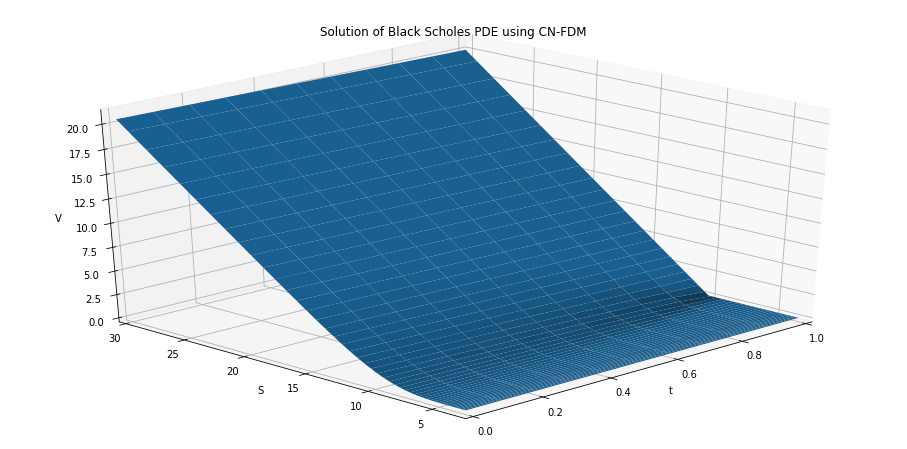

In [71]:
N = 10;
TAU = 0.5*sigma**2*T
tau = np.linspace(0, TAU, N+1)
delta_tau = TAU / N

x_min = np.log(S_min/K); x_max = np.log(S_max/K)
M = math.ceil((x_max-x_min)/delta_tau) #choose M such that delta_x = delta_t
s = np.linspace(S_min, S_max, M+2)
x = np.linspace(x_min, x_max, M+2)
s1 = K*np.exp(x)

delta_x = (x_max - x_min) / (M+1) #approx. delta_t


l = delta_tau / delta_x**2
k= (2*r) / sigma**2
u = CN_fdm(M, N, l, tau, x, k)

#transform everything back
x, tau = np.meshgrid(x, tau)
S = K * np.exp(x) # x = ln(S/k)
t = T - (2/sigma**2)*tau # tau = 1/2 * (sigma**2*(T-t))
v = u * np.exp((-0.5*(k-1))*x+(-0.25*(k+1)**2)*tau) # w = v * exp(-alpha*x-beta*tau)
V = v * K # v = V/K

#We could not use s = np.linspace(S_min, S_max, M+2) directly. 
#The difference can be found by printing S and s.
#print(S[1],'\n',s)

#plot the solution
fig = plt.figure()
plt.figure(figsize=(16, 8))
ax = plt.axes(projection='3d')
ax.set_title('Solution of Black Scholes PDE using CN-FDM')
ax.set_xlabel('t')
ax.set_ylabel('S')
ax.set_zlabel('V')

surf = ax.plot_surface(t, S, V)
ax.view_init(30, -135)
ax.set_xlim([0,1])
ax.set_ylim([3,30])
ax.set_zlim([0,30-0.9*K])

## Compare the result for $S_0 = 12$ using exact solution from Black Scholes equation and the approximated one from CN scheme using different step sizes (or discretization points)

In [72]:
S0 = 12
N = [5, 10, 15, 20]
M = [255, 511, 767, 1023]
V_ex = BS_exact(sigma, r, K, S0, T)
V_app = np.zeros(len(N))
error_V = np.zeros(len(N))
x_min = np.log(S_min/K)
x_max = np.log(S_max/K)
k = (2*r)/sigma**2

for i in range(len(N)):
    #discretized transformed time domain as a vector 
    tau = np.linspace(0, 0.5*sigma**2*T, N[i]+1)
    dtau = (0.5*sigma**2*T)/N[i]

    #discretized transformed stock domain as a vector
    x = np.linspace(x_min, x_max, M[i]+2)
    dx = (x_max - x_min)/(M[i]+1)
    #calculate lambda
    l = dtau/dx**2

    #solving the heat equation with CN 
    u = CN_fdm(M[i], N[i], l, tau, x, k)
    v = np.zeros([np.size(u,0), np.size(u,1)])
    #transform everything back
    s = np.linspace(S_min, S_max, M[i]+2)
    t = np.linspace(0, T, N[i]+1)

    alpha = (0.5 - r / sigma**2); beta = -0.25*(2*r/sigma**2 + 1)**2;
    for ii in range(0, len(tau)):
        for jj in range(0, len(x)):
            v[ii,jj] = u[ii,jj] * np.exp(alpha*x[jj]+beta*tau[ii])
    V = v * K
    V=np.flipud(V)
    # calculate the value of y(S0)
    y = interp1d(K*np.exp(x), V[0, :]) 
    V_app[i] = y(S0)
    error_V[i] = abs(V_app[i] - V_ex)
    
x = PrettyTable()
x.field_names = ["N", "M", "V_ex ", "V_app", "error_V"]
x.add_row([N[0], M[0], V_ex, V_app[0], error_V[0]])
x.add_row([N[1], M[1], V_ex, V_app[1], error_V[1]])
x.add_row([N[2], M[2], V_ex, V_app[2], error_V[2]])
x.add_row([N[3], M[3], V_ex, V_app[3], error_V[3]])
print(x)

+----+------+--------------------+--------------------+-----------------------+
| N  |  M   |       V_ex         |       V_app        |        error_V        |
+----+------+--------------------+--------------------+-----------------------+
| 5  | 255  | 2.8880430932111443 |  2.88962443686363  |  0.001581343652485856 |
| 10 | 511  | 2.8880430932111443 | 2.888202116922048  | 0.0001590237109039272 |
| 15 | 767  | 2.8880430932111443 | 2.8881147783306598 | 7.168511951549661e-05 |
| 20 | 1023 | 2.8880430932111443 | 2.8880842504543462 | 4.115724320197245e-05 |
+----+------+--------------------+--------------------+-----------------------+


## Part 2: Finite element method

**FEM**: Consider the heat equation with Dirichlet boundary conditions
$$ u(\tau, x_{min}) = \bar{\alpha}(\tau), \quad u(\tau, x_{max}) = \bar{\beta}(\tau).$$
Substituting the approximation ansatz
$$
  w = \sum_{i=1}^{m-1}c_i(\tau)\varphi_i(x) + \varphi_b(\tau,x), \quad \varphi_b(\tau,x) := (\bar{\beta}(\tau) - \bar{\alpha}(\tau))\frac{x-x_{min}}{x_{max}-x_{min}} + \bar{\alpha}(\tau)
$$
into the heat equation leads to the Galerkin approach.
Therefore we obtain the following system of ODEs
$$
  B\dot{c} + b = - A c
$$

with the known matrices $A, B$ and 
$$
  b(\tau) = \left(\int\dot{\varphi_b}\varphi_1\,dx, \cdots, \int\dot{\varphi_b}\varphi_{m-1}\,dx \right)^{\top}.
$$
Consider a European Call-option and use its boundary conditions $\bar{\alpha}(\tau), \bar{\beta}(\tau)$. Find the approximation of the price $V$ following the steps:
*   derive the vector $b(\tau)$ analytically
*   solve the ODEs for the unknown vector $c_1, \cdots , c_{m−1}$. For this discretize time $\tau$ from Crank-Nicolson method as:

$$
  (B+\frac{\Delta \tau}{2}A)c^{(\nu +1)} = (B-\frac{\Delta \tau}{2}A)c^{(\nu)} - \frac{\Delta \tau}{2}(b^{(\nu)}+b^{(\nu+1)})
$$
* compute $w$ from the ansatz as the approximated solution of the heat equation and transform it back to the approximation of the option price






## Define functions that return the function to compensate the boundary conditions, namely $\varphi_b(\tau, x)$, and the IC

In [73]:
def phi_b(tau, x_min, x_max, x, k):
    """
      Function to compensate for the BC FEM

      Input:  tau   -> time value
              x_max -> maximim space value
              x_min -> minimum space value
              x     -> space points
              k     -> constant, k = (2r)/sigma^2


      Output: phi_b

    """

    alpha_tau =0
    beta_tau = np.exp(0.5*(k+1)*x_max + 0.25*(k+1)**2*tau) - np.exp(0.5*(k-1)*x_max + 0.25*(k-1)**2*tau)
    phi_b = beta_tau * (x - x_min) / (x_max - x_min)
    return phi_b

In [74]:
def c0(tau_0, x_min, x_max, x, k):
    """
      Function that return IC at tau = 0 for a call option, for the coefficients of the FEM method

      Input:  tau_0   -> time value t_0
              x_max -> maximim space value
              x_min -> minimum space value
              x     -> space points
              k     -> constant, k = (2r)/sigma^2

      Output: IC value at tau = 0

    """
    IC = np.exp(0.5*(k-1)*x)*np.maximum(np.zeros((len(x))), np.exp(x)-1) - phi_b(tau_0, x_min, x_max, x, k)
    return IC

## Define a function that return the vector $b(\tau, x)$ at a time point

In [75]:
def b(tau, x_min, x_max, delta_x, x, k):
    """
      Function that return the vector b FEM

      Input:  tau     -> time value
              x_max   -> maximim space value
              x_min   -> minimum space value
              delta_x -> space step size
              x       -> space points as vector
              k       -> constant, k = (2r)/sigma^2


      Output: b

    """
    b=((-(k+1)**2/4)*np.exp((k+1)*x/2+(k+1)**2*tau/4)+((k-1)**2/4)*np.exp((k-1)*x/2+(k-1)**2*tau/4))*(2*delta_x**2/3)
    
    
    #Beta_tau = np.exp(0.5*(k+1)*x_max + 0.25*(k+1)**2*tau) - np.exp(0.5*(k-1)*x_max + 0.25*(k-1)**2*tau)
    #dBeta_tau = 0.25*(k+1)**2*Beta_tau
    #b = (x - x_min)/(x_max - x_min)*delta_x*dBeta_tau
    """
    alpha = 1/2*(k+1)
    b = np.zeros((len(x)))
    B = np.zeros((len(x)))
    C = np.zeros((len(x)))
    D = np.zeros((len(x)))
    # calculate the integral with integration by parts
    for k in range (1, M-1):
        # define A, B, C, D, which are terms resulting from integration by parts
        A = alpha**2*1/(x_max-x_min)*np.exp(alpha**2*tau)*1/delta_x
        # B is the solution of the integral exp(alpha*x)
        B[k] = 1/alpha*(np.exp(alpha*x[k+1]) * np.exp(alpha*x[k]))
        # C is the solution of the integral x*exp(alpha*x)
        C[k] = 1/alpha**2*((alpha*x[k+1]-1)*np.exp(alpha*x[k+1]) + (1-alpha*x[k])*np.exp(alpha*x[k]))
        # D  is the solution of the integral x^2*exp(alpha*x)
        D[k] = 1/alpha**3*((alpha**2*x[k+1]**2-2*alpha*x[k+1]+2)*np.exp(alpha*x[k+1]) + (-alpha**2*x[k]**2+2*alpha*x[k]-2)*np.exp(alpha*x[k]))
    
        #calculate b
        b[k] = A * (D[k] - x[0]*C[k] - x_min*C[k] + x[0]*x_min*B[k] + x[2]*C[k] - D[k] - x_min*x[2]*B[k] + x_min*C[k])
    """ 
    return b

## Define a function to perform the FEM using Galerkin method and the Crank-Nicolson for the ODE system, and use ansatz to get the solution of the heat equation

In [76]:
def G_CN_fem(M, N, x_min, x_max, delta_x, delta_tau, tau, x, k):
    """
      Function that return the solution of the heat equation using fem method

      Input:  M         -> space length (without BC)
              N         -> time length (without IC)
              x_min     -> minimum space value
              x_max     -> maximim space value
              delta_x   -> space step size
              delta_tau -> time step size
              tau       -> time points as vector with initial point 0
              x         -> space points as vector with boundary
              k         -> constant, k = (2r)/sigma^2

      Output: W   -> solution of the heat equation using fem method

    """
    c = np.zeros((N+1, M))
    #A = np.zeros((M,M)); B = np.zeros((M,M))
    #A construction
    A_m = np.array([-1*np.ones(M-1),2*np.ones(M),-1*np.ones(M-1)])
    offset = [-1,0,1]
    A = 1/delta_x*diags(A_m,offset).toarray()

    #B construction
    B_m = np.array([1*np.ones(M-1),4*np.ones(M),1*np.ones(M-1)])
    
    B = delta_x/6*diags(B_m,offset).toarray()

    c[0, :] = c0(0, x_min, x_max, x[1:M+1], k)
    Temp  = B + (delta_tau/2) * A
    Temp1 = np.linalg.inv(Temp)
    Temp2 = B - delta_tau/2 * A
    
    for i in range(0, N):
        bv = b(tau[i], x_min, x_max, delta_x, x[1:M+1], k)
        bv1= b(tau[i+1], x_min, x_max, delta_x, x[1:M+1], k)
        c[i+1,:] = Temp1.dot(Temp2.dot(c[i,:]) - delta_tau/2*(bv + bv1))
    
    w = np.zeros((N+1, M+2))
    w[:,M+1] = phi_b(tau, x_min, x_max, x[M+1], k) #np.exp(0.5*(k+1)*x_max+0.25*(k+1)**2*tau)
    w[:,0] = 0 #don't need to declare again, but just make it clear
    #Since for any 𝑥 = 𝑥_i, i.e. on the nodes, we have 𝜑_i(𝑥) = 1
    for i in range(0, len(tau)):
        for j in range(0, M):
            w[i,j+1] = c[i,j] + phi_b(tau[i], x_min, x_max, x[j+1], k)
    #print(w[-1][-1])
    return w    

## Visualize the solution for N = 10

* Choose M such that the $\Delta\tau$ and $\Delta x$ are the same.

(0, 21)

<Figure size 432x288 with 0 Axes>

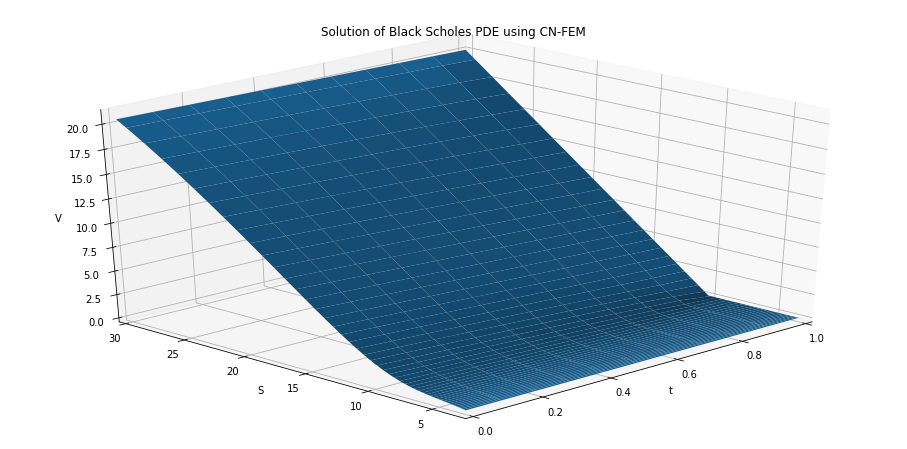

In [77]:
N = 10;
TAU = 0.5*sigma**2*T
tau = np.linspace(0, TAU, N+1)
delta_tau = TAU / N

x_min = np.log(S_min/K); x_max = np.log(S_max/K)
M = math.ceil((x_max-x_min)/delta_tau-1) #choose M such that delta_x = delta_t
s = np.linspace(S_min, S_max, M+2)
x = np.linspace(x_min, x_max, M+2)
delta_x = (x_max - x_min) / (M+1) #approx. delta_t
l = delta_tau / delta_x**2
k= (2*r) / sigma**2

u = G_CN_fem(M, N, x_min, x_max, delta_x, delta_tau, tau, x, k)

x, tau = np.meshgrid(x, tau)
S = K * np.exp(x) # x = ln(S/k)
t = T - (2/sigma**2)*tau # tau = 1/2 * (sigma**2*(T-t))
v = u * np.exp((-0.5*(k-1))*x+(-0.25*(k+1)**2)*tau) # w = v * exp(-alpha*x-beta*x)
V = v * K # v = V/K

#plot the solution
fig = plt.figure()
plt.figure(figsize=(16, 8))
ax = plt.axes(projection='3d')
ax.set_title('Solution of Black Scholes PDE using CN-FEM')
ax.set_xlabel('t')
ax.set_ylabel('S')
ax.set_zlabel('V')

surf = ax.plot_surface(t, S, V)
ax.view_init(30, -135)
ax.set_xlim([0,1])
ax.set_ylim([3,30])
ax.set_zlim([0,21]) #[0, S_max-0.9K]

## Compare the result for $S_0 = 12$ using exact solution from Black Scholes equation, the approximated one from CN fdm scheme and the one with fem using different step sizes (or discretization points)

In [78]:
S0 = 12
N = [5, 10, 10, 10]
M = [255, 511, 2000, 5000 ]
V_ex = BS_exact(sigma, r, K, S0, T)
V_app = np.zeros(len(N))
error_V = np.zeros(len(N))
x_min = np.log(S_min/K)
x_max = np.log(S_max/K)
k = (2*r)/sigma**2

for i in range(len(N)):
    #discretized transformed time domain as a vector 
    tau = np.linspace(0, 0.5*sigma**2*T, N[i]+1)
    dtau = (0.5*sigma**2*T)/N[i]

    #discretized transformed stock domain as a vector
    x = np.linspace(x_min, x_max, M[i]+2)
    dx = (x_max - x_min)/(M[i]+1)

    #calculate lambda
    l = dtau/dx**2

    #solving the heat equation with CN 
    w = G_CN_fem(M[i], N[i], x_min, x_max, delta_x, delta_tau, tau, x, k)
    #transform everything back
    s = np.linspace(S_min, S_max, M[i]+2)
    t = np.linspace(0, T, N[i]+1)

    x, tau = np.meshgrid(x, tau)
    S = K * np.exp(x)
    t = T - (2/sigma**2)*tau
    v = w * np.exp((-0.5*(k-1))*x+(-0.25*(k+1)**2)*tau)
    V = v * K
    
    # calculate the value of y(S0)
    y = interp1d(S[0, :], V[N[i], :])
    V_app[i] = y(S0)
    error_V[i] = abs(V_app[i] - V_ex)
    
x = PrettyTable()
x.field_names = ["N", "M", "V_ex ", "V_app", "error_V"]
x.add_row([N[0], M[0], V_ex, V_app[0], error_V[0]])
x.add_row([N[1], M[1], V_ex, V_app[1], error_V[1]])
x.add_row([N[2], M[2], V_ex, V_app[2], error_V[2]])
x.add_row([N[3], M[3], V_ex, V_app[3], error_V[3]])
print(x)

+----+------+--------------------+-------------------+----------------------+
| N  |  M   |       V_ex         |       V_app       |       error_V        |
+----+------+--------------------+-------------------+----------------------+
| 5  | 255  | 2.8880430932111443 | 4.709543421396514 |  1.8215003281853699  |
| 10 | 511  | 2.8880430932111443 | 3.818023932511131 |  0.9299808392999869  |
| 10 | 2000 | 2.8880430932111443 | 2.872018179739567 | 0.016024913471577307 |
| 10 | 5000 | 2.8880430932111443 | 2.838496840158074 | 0.049546253053070366 |
+----+------+--------------------+-------------------+----------------------+
